# 리뷰 기반 게임 검색

In [4]:
import os
import time
import pickle
import joblib
import sys

import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer #CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import nltk

from nltk.corpus import stopwords
from collections import Counter

# 추가한 라이브러리
import re
import joblib

import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display



In [5]:
# read Dataset of 크롤링

with open("preprocessing/game_pkl/game_df_b150.pkl","rb") as fr:
    game_df = pickle.load(fr)

In [6]:
game_df.head()

,platform_2,platform,title,publisher,static,detail,0,1,2,3,...,90,91,92,93,94,95,96,97,98,99
0,1,DS,Ghost Trick: Phantom Detective,Capcom,"{'user': {'positive': 1552, 'mixed': 12, 'nega...",{'summary': 'Ghost Trick is a story of mystery...,"{'score': 10, 'review': 'Easily one of the bes...","{'score': 9, 'review': 'Hands down, one of the...","{'score': 10, 'review': 'Innovative and addict...","{'score': 10, 'review': 'Phenomenal. This game...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,PSP,Z.H.P. Unlosing Ranger vs Darkdeath Evilman,NIS America,"{'user': {'positive': 1038, 'mixed': 3, 'negat...",{'summary': 'Known as ZettaiHero Keikakuin Jap...,"{'score': 8, 'review': 'Probably the best rogu...","{'score': 8, 'review': 'If you aren't familiar...","{'score': 10, 'review': 'NIS has always writte...","{'score': 9, 'review': 'It is really amazing t...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Xbox Series X,MADiSON,Perp Games,"{'user': {'positive': 97, 'mixed': 1, 'negativ...",{'summary': 'What would you do if you woke up ...,"{'score': 1, 'review': 'It's a very short game...","{'score': 2, 'review': 'The game is very poorl...","{'score': 10, 'review': 'Best horror experienc...","{'score': 10, 'review': 'An Argentine game tha...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,PC,Atelier Sophie 2: The Alchemist of the Mysteri...,Koei Tecmo Games,"{'user': {'positive': 54, 'mixed': 1, 'negativ...",{'summary': 'A mysterious story of a mysteriou...,"{'score': 10, 'review': 'The game turned out w...","{'score': 10, 'review': 'I finished today Atel...","{'score': 10, 'review': 'Wow! Atelier Sophie 2...","{'score': 0, 'review': 'The game is good, ther...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Switch,Dynasty Warriors 9 Empires,Koei Tecmo Games,"{'user': {'positive': 59, 'mixed': 0, 'negativ...","{'summary': 'Empires, a unique ""Romance of the...","{'score': 10, 'review': 'I love this game so m...","{'score': 10, 'review': 'Totally entertained f...","{'score': 10, 'review': 'I really wasn't expec...","{'score': 0, 'review': 'bad graphics, the soun...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
print('''리뷰 유사도 분석을 통한 머신러닝 모델입니다.\n
평소 즐겨 하는 platform 을 선택하세요
PC      : 0
Console : 1

'''
     )

while True:
    
    platform = int(input())
    if platform == 1:
        print('Console game을 선택하셨습니다.\n게임 목록입니다.')
        print(game_df[game_df['platform_2'] == platform]['title'])
        
        break
        
    elif platform == 0:
        print('PC game을 선택하셨습니다.\n게임 목록입니다.')
        print(game_df[game_df['platform_2'] == platform]['title'])
        
        break
    
    else:
        print('올바르게 입력하세요')

리뷰 유사도 분석을 통한 머신러닝 모델입니다.

평소 즐겨 하는 platform 을 선택하세요
PC      : 0
Console : 1


0
PC game을 선택하셨습니다.
게임 목록입니다.
3      Atelier Sophie 2: The Alchemist of the Mysteri...
5                             Dynasty Warriors 9 Empires
6                               Monster Rancher 1 & 2 DX
8                     Fatal Frame: Maiden of Black Water
12                                       Resident Evil 2
13                          Final Fantasy XIV: Endwalker
16                         Final Fantasy XIV: Stormblood
17                                               OneShot
19            The Witcher 3: Wild Hunt - Hearts of Stone
30                                           Left 4 Dead
34                                       Team Fortress 2
39                                Medieval II: Total War
47                                 Day of Defeat: Source
50                                       Rome: Total War
54                Star Wars: Knights of the Old Republic
60                                  

In [8]:
#불용어 사전
stop_words = stopwords.words("english")

#불용어 추가
stop_words.append(',')
stop_words.append('(')
stop_words.append(')')
stop_words.append('.')
stop_words.append('!')
stop_words.append("'")
stop_words.append("`")
stop_words.append('"')

# 불용어 삭제
#  stop_words.append('\\')

In [9]:
#모든 리뷰 꺼내며 불용어 처리
b_games_review = []
for k in range(len(game_df)):   
    game_review = ''
    for i in range(100):
    
        try:
            game_review = game_review + game_df.iloc[k][i]['review']

        except:
            pass
    
    sentence = game_review
    
    #문장 토큰화
    tokens = nltk.word_tokenize(sentence)
    
    # 불용어 처리
    result = []
    for token in tokens:
        if token.lower() not in stop_words:
            result.append(token.lower())
    
    # 문장 재봉합
    game_review = ''
    for k in result:
        game_review = game_review + ' ' + k

            
    b_games_review.append(game_review)
    

#b_games_review[0]

In [10]:
# ※정규식 필터링 추가

review_word_pattern = re.compile(r'[A-Za-z]+')

# 복잡해 보이지만 로직은 별거 없고
# b_~ 리스트를 순회하며 각 문자열을 정규식 적용하여 단어 분리
# 그 후 길이가 3 이상인 단어만 뽑아 묶은 문자열로 교체
b_games_review = [' '.join([word if len(word) > 2 else '' \
                            for word in re.findall(review_word_pattern, review)]) \
                  for review in b_games_review]

In [11]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(b_games_review)

In [12]:
# pd.DataFrame(cosine_similarity(X))

In [13]:
# 유사도가 일정치를 넘는 결과 보기

# cos_array = cosine_similarity(X)
# threshold = 0.6

# for i in range(50):
#     for j in range(i+1, 50):
#         if cos_array[i][j] > threshold:
#             print(game_df.at[i, 'title'], game_df.at[i, 'platform'], '||',game_df.at[j, 'title'], game_df.at[j, 'platform'])

In [27]:
#게임정보 출력 함수화
def game_info(game_index):
    
    img = Image.open("preprocessing/GameImage/"+str(game_index)+".png")
    display(img)
    img.close()
    
    print('\n게임의 정보입니다.\n\n'+ game_df['title'][game_index]+ '\n' +
      
    '******************************\n'
    'Platform : ' + game_df['platform'][game_index] + '\n'
    'user   Score ' + str(int(game_df['static'][game_index]['user']['mean']) * 10) + '/100\n'
    'static Score ' + str(game_df['static'][game_index]['critic']['mean'])+ '/100\n'
    '**********게임설명*************\n' + game_df['detail'][game_index]['summary']
    )

해보고 싶은 Game의 번호를 선택하세요
3


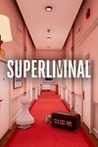


게임의 정보입니다.

Atelier Sophie 2: The Alchemist of the Mysterious Dream
******************************
Platform : PC
user   Score 90/100
static Score 83/100
**********게임설명*************
A mysterious story of a mysterious dream...
One of the stories experienced throughout the Alchemist Sophie’s many adventures, as she continued her travels after leaving her hometown of Kirchen Bell.
This is Sophie’s adventure as she searches for her friend Plachta in the dream world Erde Wiege, where they become separated, and shows the bonds she forms with the people she meets and passing of hearts.

■Evolved turn-based battles & seamless transitions!
In the 6 member party turn-based battles, the 3 members in the front and 3 in the back form 2 teams cooperating “multi-linked turn battles”, and transitions from exploration to battles without loading times in “seamless battles”, the entire game can be enjoyed at a great pace.

■2 types of panels for everyone to enjoy synthesis!
This game uses panel synthesis

In [32]:
print('해보고 싶은 Game의 번호를 선택하세요')

whlie_n = 0
while True:
    
    game_index = int(input())

    for k in game_df[game_df['platform_2'] == platform]['title'].index:
        if k == game_index:
            whlie_n = 1
    
    if whlie_n == 1:
        break
    else:
        print('없는 Game의 번호입니다. 다시 입력해주세요')
        
print(game_info(game_index))

********************리뷰기반 추천게임********************

리뷰가 가장 비슷한 상위 3가지 게임 입니다.




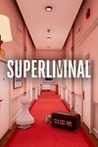


게임의 정보입니다.

Atelier Sophie 2: The Alchemist of the Mysterious Dream
******************************
Platform : PC
user   Score 90/100
static Score 83/100
**********게임설명*************
A mysterious story of a mysterious dream...
One of the stories experienced throughout the Alchemist Sophie’s many adventures, as she continued her travels after leaving her hometown of Kirchen Bell.
This is Sophie’s adventure as she searches for her friend Plachta in the dream world Erde Wiege, where they become separated, and shows the bonds she forms with the people she meets and passing of hearts.

■Evolved turn-based battles & seamless transitions!
In the 6 member party turn-based battles, the 3 members in the front and 3 in the back form 2 teams cooperating “multi-linked turn battles”, and transitions from exploration to battles without loading times in “seamless battles”, the entire game can be enjoyed at a great pace.

■2 types of panels for everyone to enjoy synthesis!
This game uses panel synthesis

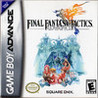


게임의 정보입니다.

Atelier Sophie 2: The Alchemist of the Mysterious Dream
******************************
Platform : Switch
user   Score 90/100
static Score 80/100
**********게임설명*************
A mysterious story of a mysterious dream...
One of the stories experienced throughout the Alchemist Sophie’s many adventures, as she continued her travels after leaving her hometown of Kirchen Bell.
This is Sophie’s adventure as she searches for her friend Plachta in the dream world Erde Wiege, where they become separated, and shows the bonds she forms with the people she meets and passing of hearts.

■Evolved turn-based battles & seamless transitions!
In the 6 member party turn-based battles, the 3 members in the front and 3 in the back form 2 teams cooperating “multi-linked turn battles”, and transitions from exploration to battles without loading times in “seamless battles”, the entire game can be enjoyed at a great pace.

■2 types of panels for everyone to enjoy synthesis!
This game uses panel synth

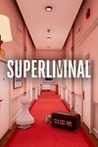


게임의 정보입니다.

Atelier Sophie 2: The Alchemist of the Mysterious Dream
******************************
Platform : PC
user   Score 90/100
static Score 83/100
**********게임설명*************
A mysterious story of a mysterious dream...
One of the stories experienced throughout the Alchemist Sophie’s many adventures, as she continued her travels after leaving her hometown of Kirchen Bell.
This is Sophie’s adventure as she searches for her friend Plachta in the dream world Erde Wiege, where they become separated, and shows the bonds she forms with the people she meets and passing of hearts.

■Evolved turn-based battles & seamless transitions!
In the 6 member party turn-based battles, the 3 members in the front and 3 in the back form 2 teams cooperating “multi-linked turn battles”, and transitions from exploration to battles without loading times in “seamless battles”, the entire game can be enjoyed at a great pace.

■2 types of panels for everyone to enjoy synthesis!
This game uses panel synthesis

In [33]:
print('''********************리뷰기반 추천게임********************

리뷰가 가장 비슷한 상위 3가지 게임 입니다.

''')

for k in range(3):

    game_index = pd.DataFrame(cosine_similarity(X,X)).sort_values(game_index, ascending= False)[game_index].index[k]
    print(game_info(game_index))
